In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
cohort = mre_pinn.data.ImagingCohort(['0006'])
cohort.load_images()
cohort.preprocess()
dataset = cohort.to_dataset()
dataset.save_xarrays('../data/NAFLD3')

In [3]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD3', '0006')
example.metadata

Loading ../data/NAFLD3/0006/wave.nc
Loading ../data/NAFLD3/0006/mre.nc
Loading ../data/NAFLD3/0006/mre_mask.nc


size   spacing    origin     limit    center    extent
variable dimension                                                        
wave     x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre      x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre_mask x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000

In [4]:
example.describe()

,,dtype,count,mean,std,min,25%,50%,75%,max
variable,component,,,,,,,,,
wave,scalar,float64,262144.0,1.391071,235.879134,-996.09375,-44.921875,0.0,47.363281,996.09375
mre,scalar,int16,262144.0,1505.871937,1335.735833,0.00000,0.000000,1340.0,2212.000000,14078.00000
mre_mask,scalar,float32,262144.0,0.171467,0.376916,0.00000,0.000000,0.0,0.000000,1.00000


<IPython.core.display.Javascript object>


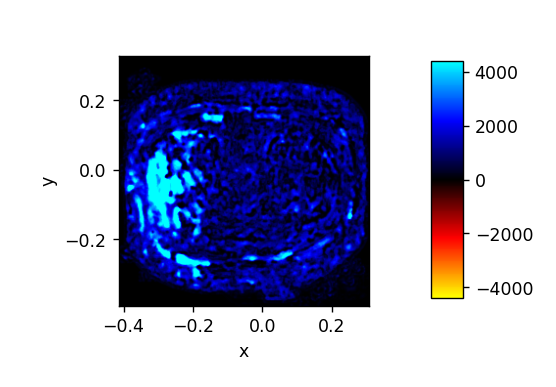

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [19]:
example.eval_baseline(frequency=40, polar=True, postprocess=True)
example.view('base', ax_height=2, ax_width=2)

In [46]:
%autoreload
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=40, detach=True)

In [47]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=4,
    n_hidden=128,
    polar_input=True,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (output): Linear(in_features=390, out_features=1, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (output): Linear(in_features=390, out_features=1, bias=True)
  )
)

In [40]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-18],
    pde_warmup_iters=10000,
    pde_step_iters=5000,
    pde_init_weight=1e-19,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000224 s



In [41]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0011s (13.88%)
Model time/iter: 0.0007s (9.37%)
Loss time/iter:  0.0061s (76.75%)
Total time/iter: 0.0080s
Total time: 0.7982s
1k iters time: 0.13m
10k iters time: 1.33m
100k iters time: 0.22h


<IPython.core.display.Javascript object>


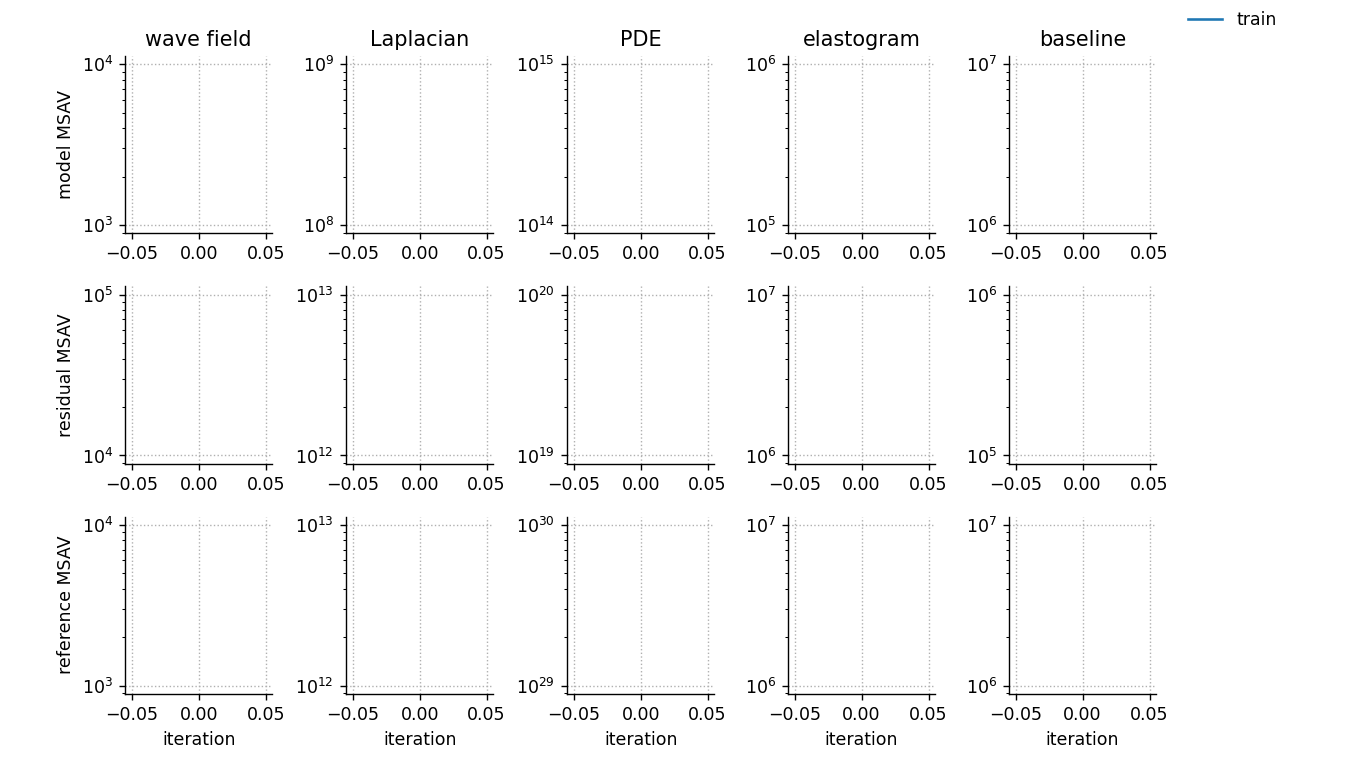

<IPython.core.display.Javascript object>


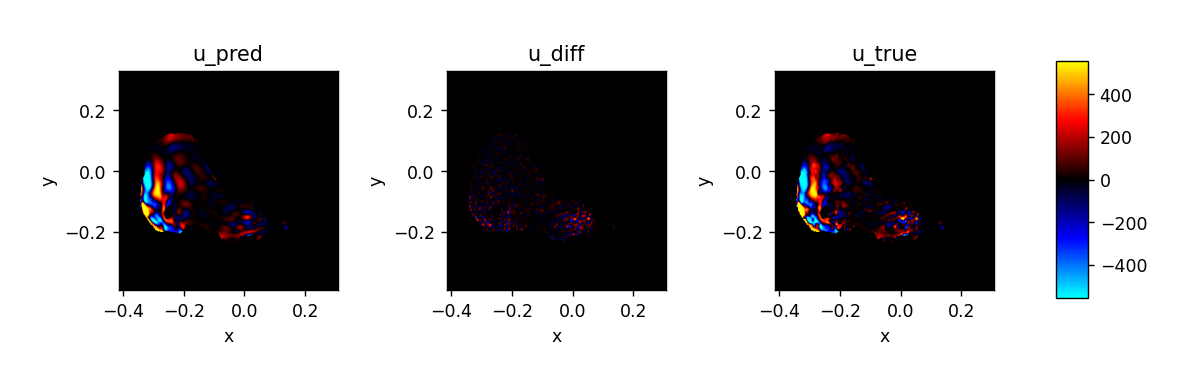

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


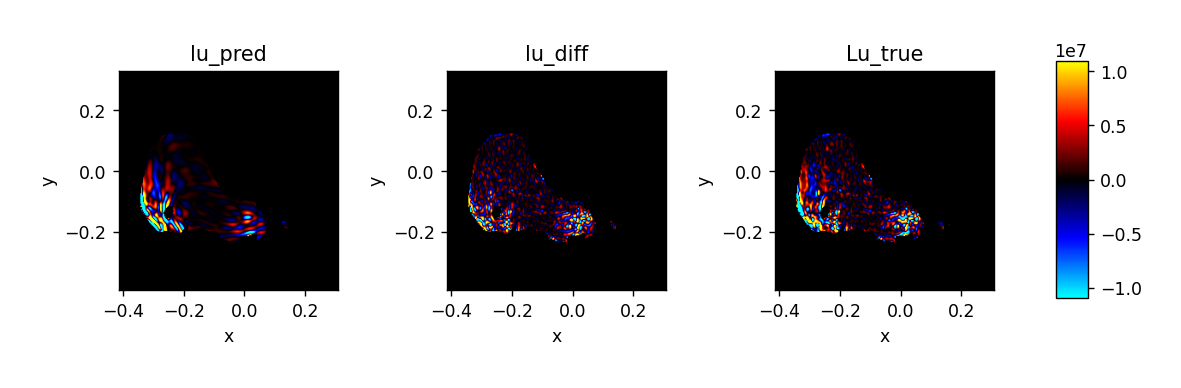

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


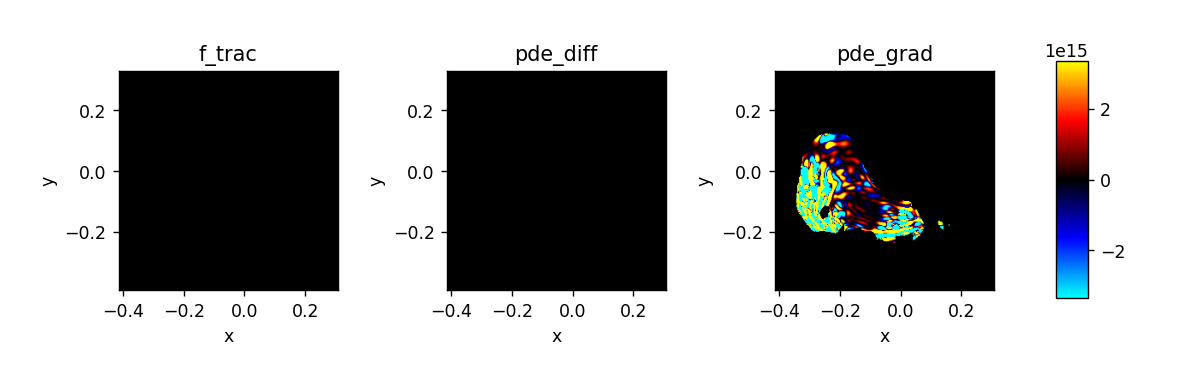

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


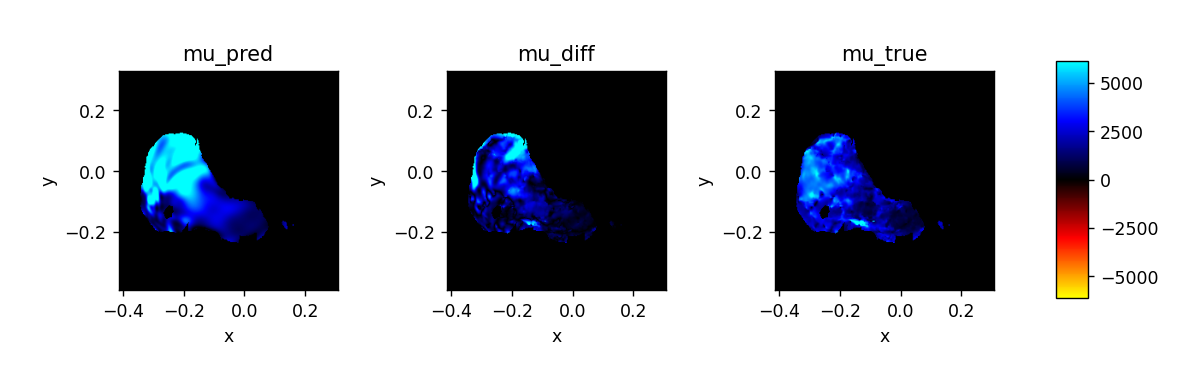

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


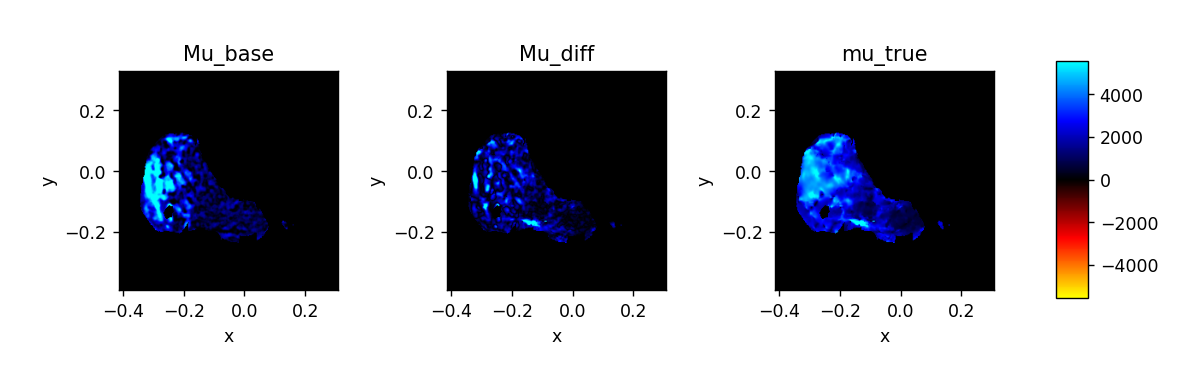

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [42]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.25e+04, 0.00e+00, 0.00e+00]    [1.02e+05, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


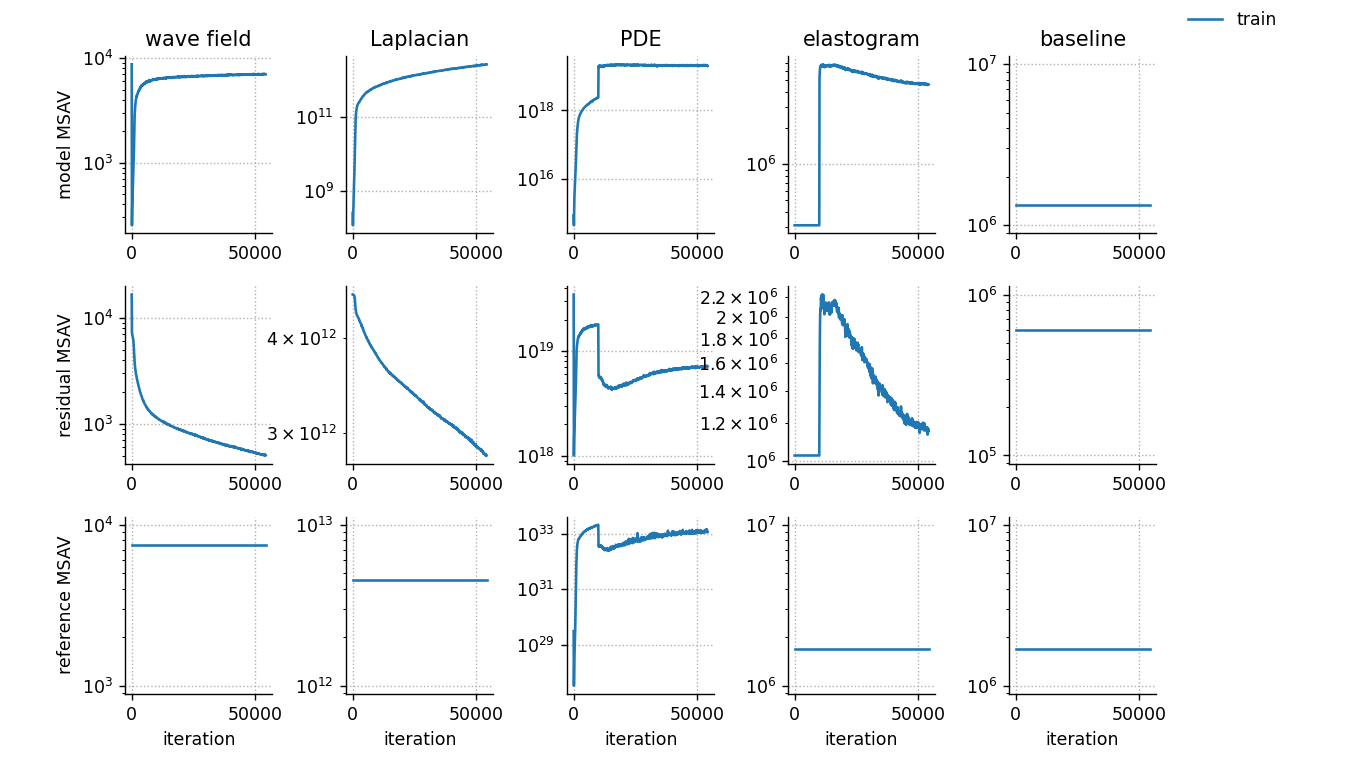

Time spent testing: 16.0071 (31.47%)
Time spent testing: 15.1804 (46.09%)
Time spent testing: 15.0694 (54.83%)
Time spent testing: 14.7099 (58.80%)
Time spent testing: 15.1504 (63.19%)
Time spent testing: 14.9677 (64.95%)
Time spent testing: 15.2351 (66.53%)
Time spent testing: 15.0770 (67.94%)
Time spent testing: 15.0629 (68.32%)
Time spent testing: 15.0753 (70.01%)
1000      [2.51e+04, 0.00e+00, 0.00e+00]    [2.81e+04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.6219 (70.10%)
Time spent testing: 15.0078 (71.42%)
Time spent testing: 15.1878 (71.34%)
Time spent testing: 15.1229 (72.43%)
Time spent testing: 14.6768 (72.58%)
Time spent testing: 15.0640 (72.65%)
Time spent testing: 14.5458 (73.02%)
Time spent testing: 15.0173 (73.17%)
Time spent testing: 15.0566 (73.91%)
Time spent testing: 15.0872 (73.90%)
2000      [1.70e+04, 0.00e+00, 0.00e+00]    [1.80e+04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.5925 (74.51%)
Time spent testing: 15.0592 (74.39%)
Time spent testing: 

Time spent testing: 15.6192 (82.59%)
Time spent testing: 15.7125 (82.63%)
Time spent testing: 15.5395 (82.62%)
Time spent testing: 15.9333 (82.61%)
Time spent testing: 15.7804 (82.65%)
Time spent testing: 15.5447 (82.67%)
Time spent testing: 15.6269 (82.72%)
Time spent testing: 15.1377 (82.74%)
19000     [5.28e+03, 0.00e+00, 2.90e+01]    [6.39e+03, 0.00e+00, 3.13e+01]    []  
Time spent testing: 15.8300 (82.72%)
Time spent testing: 15.3997 (82.75%)
Time spent testing: 15.9025 (82.72%)
Time spent testing: 15.7099 (82.76%)
Time spent testing: 15.5025 (82.73%)
Time spent testing: 15.7761 (82.75%)
Time spent testing: 15.6631 (82.76%)
Time spent testing: 16.0625 (82.75%)
Time spent testing: 15.6243 (82.79%)
Time spent testing: 15.2314 (82.83%)
20000     [5.15e+03, 0.00e+00, 2.73e+01]    [6.26e+03, 0.00e+00, 3.03e+01]    []  
Time spent testing: 15.6684 (82.86%)
Time spent testing: 15.2220 (82.85%)
Time spent testing: 15.8103 (82.83%)
Time spent testing: 15.2639 (82.86%)
Time spent testing: 

Time spent testing: 16.0147 (83.55%)
Time spent testing: 16.0107 (83.57%)
Time spent testing: 16.3303 (83.56%)
38000     [3.89e+03, 0.00e+00, 3.52e+01]    [4.52e+03, 0.00e+00, 3.48e+01]    []  
Time spent testing: 17.7141 (83.55%)
Time spent testing: 18.3809 (83.55%)
Time spent testing: 16.0847 (83.54%)
Time spent testing: 16.2916 (83.56%)
Time spent testing: 16.0485 (83.55%)
Time spent testing: 16.1511 (83.57%)
Time spent testing: 16.3761 (83.58%)
Time spent testing: 15.9294 (83.60%)
Time spent testing: 16.0297 (83.62%)
Time spent testing: 15.8333 (83.61%)
39000     [3.18e+03, 0.00e+00, 3.43e+01]    [4.56e+03, 0.00e+00, 3.61e+01]    []  
Time spent testing: 16.2609 (83.63%)
Time spent testing: 16.1676 (83.61%)
Time spent testing: 15.8729 (83.62%)
Time spent testing: 16.4318 (83.62%)
Time spent testing: 16.2830 (83.62%)
Time spent testing: 16.3622 (83.63%)
Time spent testing: 15.9211 (83.63%)
Time spent testing: 16.1530 (83.66%)
Time spent testing: 16.0973 (83.67%)
Time spent testing: 

KeyboardInterrupt: 

In [43]:
model.train(100000, callbacks=[test_eval])